# Studants Exam Performance - Regressão Logística - 3 classes

## Importação das bibliotecas

In [440]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython import display
%matplotlib inline

## Dataset: Leitura, normalização e visualização dos dados

In [441]:
dataset = "mrsimple07/student-exam-performance-prediction"
file_path = "student_exam_data.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    dataset,
    file_path
)
df.head(5)

/tmp/ipython-input-4110259591.py:4: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'student-exam-performance-prediction' dataset.


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


In [442]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Study Hours          500 non-null    float64
 1   Previous Exam Score  500 non-null    float64
 2   Pass/Fail            500 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [443]:
X = df[['Previous Exam Score', 'Study Hours']].values
y = df['Pass/Fail'].values

# Dividindo Dataset em Treinamento E Validação

In [444]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [445]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(350, 2)
(150, 2)
(350,)
(150,)


# Transformando os Dados para Escalas Próximas

In [446]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

### Prepara os dados para o PyTorch

In [447]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
Y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
Y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

In [448]:
print(X_train_tensor.dtype)
print(Y_train_tensor.dtype)

torch.float32
torch.float32


In [449]:
Y_train_tensor

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [450]:
X_train_tensor

tensor([[-1.1403, -1.1766],
        [-1.4941,  0.9947],
        [-0.4589,  0.5215],
        [-0.3951, -0.6796],
        [-0.8520,  0.8015],
        [-0.0620,  0.2642],
        [ 1.1288,  0.3074],
        [-1.2738,  0.4783],
        [ 1.4036,  1.3026],
        [ 0.7465, -0.3966],
        [-1.5699, -0.7282],
        [-1.5161, -1.1751],
        [ 0.5005, -0.5231],
        [ 1.3062, -1.5438],
        [ 1.4790,  1.0556],
        [ 1.5575,  1.5519],
        [-0.2615, -1.0302],
        [ 1.1592,  1.2042],
        [ 1.4794,  1.3389],
        [ 0.0473, -0.9325],
        [-0.8450, -1.3721],
        [-0.4417,  0.8537],
        [ 1.1473,  1.2850],
        [ 1.1023,  1.2927],
        [ 1.3371,  0.4239],
        [ 1.7162, -1.1150],
        [-0.2827,  0.5902],
        [-0.8082, -1.3191],
        [-1.2896, -0.7447],
        [ 1.5898, -1.4670],
        [ 0.8098,  1.6210],
        [ 0.4208, -0.5289],
        [-0.2385, -0.6266],
        [-1.1845, -0.0183],
        [-0.2477, -1.3268],
        [-0.5846, -0

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [451]:
model = nn.Linear(2,1)

In [452]:
model.state_dict()

OrderedDict([('weight', tensor([[ 0.0588, -0.4027]])),
             ('bias', tensor([0.4498]))])

### Fazendo um predict

In [453]:
out = model(X_train_tensor[:10, :])
out

tensor([[ 0.8565],
        [-0.0387],
        [ 0.2128],
        [ 0.7002],
        [ 0.0769],
        [ 0.3397],
        [ 0.3924],
        [ 0.1822],
        [ 0.0078],
        [ 0.6534]], grad_fn=<AddmmBackward0>)

In [454]:
probs = torch.sigmoid(out)
probs

tensor([[0.7019],
        [0.4903],
        [0.5530],
        [0.6682],
        [0.5192],
        [0.5841],
        [0.5969],
        [0.5454],
        [0.5019],
        [0.6578]], grad_fn=<SigmoidBackward0>)

### Predição da classe

In [455]:
y_pred = (probs >= 0.5).float()

y_pred

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])

## Treinamento

### Classe para visualização dinâmica

In [456]:
def predict(model, inputs):
    """Retorna a classe prevista (0 ou 1)."""
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        predicts = (probs >= 0.5).float()
    return predicts.numpy().ravel()

def predict_prob(model, inputs):
    """Retorna a probabilidade prevista (entre 0 e 1)."""
    with torch.no_grad():
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
    return probs.numpy().ravel()


class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h=0.01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath

        # Geração da malha de decisão
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h),
                                       np.arange(y_min, y_max, h))
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        self.loss_hist = []
        self.val_loss_hist = []

        # Configuração da figura
        self.fig = plt.figure(figsize=(12, 4), dpi=100)

        # Gráfico de perda
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, self.n_epoch)
        self.ax1.set_xlabel('Época')
        self.ax1.set_ylabel('Perda')
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([], [], 'b', linewidth=2.0, label="Treino")
        self.ax1.grid(True)

        # Fronteira de decisão
        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlabel('X₁')
        self.ax2.set_ylabel('X₂')
        self.ax2.set_title('Fronteira de decisão')

        # Probabilidades (mapa de calor)
        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlabel('X₁')
        self.ax3.set_ylabel('X₂')
        self.ax3.set_title('Mapa de probabilidades')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch % 250 == 0 or epoch == self.n_epoch - 1:
                # Gráfico de perda
                self.ax1.plot(np.arange(epoch + 1), self.loss_hist, 'b', linewidth=2.0)

                # Fronteira de decisão
                Zc = predict(self.model, torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.clear()
                self.ax2.set_title('Fronteira de decisão')
                self.ax2.contourf(self.xx, self.yy, Zc, alpha=0.7, cmap=plt.cm.Paired)
                colors = np.array(['red', 'blue'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y.astype(int)], edgecolors='k')

                # Mapa de probabilidades
                Zp = predict_prob(self.model, torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.clear()
                self.ax3.set_title('Mapa de probabilidades')
                prob_plot = self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma, shading='auto')
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y.astype(int)], edgecolors='k')

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Sigmoid

In [457]:
print(out.shape)
print(Y_train_tensor.shape, Y_train_tensor.dtype)
print(Y_train_tensor.unique())

torch.Size([10, 1])
torch.Size([350, 1]) torch.float32
tensor([0., 1.])


In [458]:
lr = 0.15

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

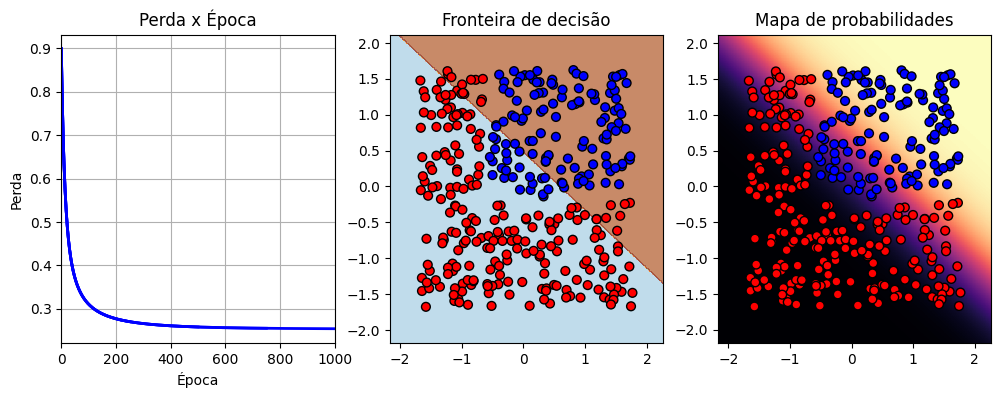

In [459]:
n_epochs = 1000
plotter = MyPlotter(model, X_train_scaled, y_train, n_epochs)
plotter.on_train_begin()

losses = []
losses_test = []
acc_list = []
acc_test_list = []

for epoch in range(n_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    predicted_classes = torch.round(outputs)

    correct_predictions = (predicted_classes == Y_train_tensor).sum().item()
    total_samples = Y_train_tensor.size(0)
    accuracy = correct_predictions / total_samples
    acc_list.append(accuracy)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)

        test_loss = criterion(test_outputs, Y_test_tensor)
        losses_test.append(test_loss.item())

        predicted_classes_test = torch.round(test_outputs)
        correct_predictions_test = (predicted_classes_test == Y_test_tensor).sum().item()
        total_samples_test = Y_test_tensor.size(0)
        accuracy_test = correct_predictions_test / total_samples_test
        acc_test_list.append(accuracy_test)

    plotter.on_epoch_end(epoch, {
        'loss': loss.item(),
        'acc': accuracy,
        'loss_test': test_loss.item(),
        'acc_test': accuracy_test
    })

    model.train()

In [460]:
print(acc_list)

[0.21428571428571427, 0.22285714285714286, 0.26285714285714284, 0.36857142857142855, 0.46, 0.5057142857142857, 0.5657142857142857, 0.6228571428571429, 0.6514285714285715, 0.6685714285714286, 0.7171428571428572, 0.7085714285714285, 0.6971428571428572, 0.6714285714285714, 0.6371428571428571, 0.6285714285714286, 0.6028571428571429, 0.5828571428571429, 0.5771428571428572, 0.5657142857142857, 0.5457142857142857, 0.5342857142857143, 0.52, 0.5, 0.4742857142857143, 0.46285714285714286, 0.4542857142857143, 0.4514285714285714, 0.44571428571428573, 0.44285714285714284, 0.44, 0.4228571428571429, 0.42, 0.4114285714285714, 0.40285714285714286, 0.39714285714285713, 0.38571428571428573, 0.37714285714285717, 0.38, 0.36857142857142855, 0.3628571428571429, 0.3628571428571429, 0.3514285714285714, 0.34285714285714286, 0.3457142857142857, 0.33714285714285713, 0.3342857142857143, 0.3314285714285714, 0.32285714285714284, 0.3171428571428571, 0.3142857142857143, 0.3142857142857143, 0.30857142857142855, 0.308571

### Gradiente

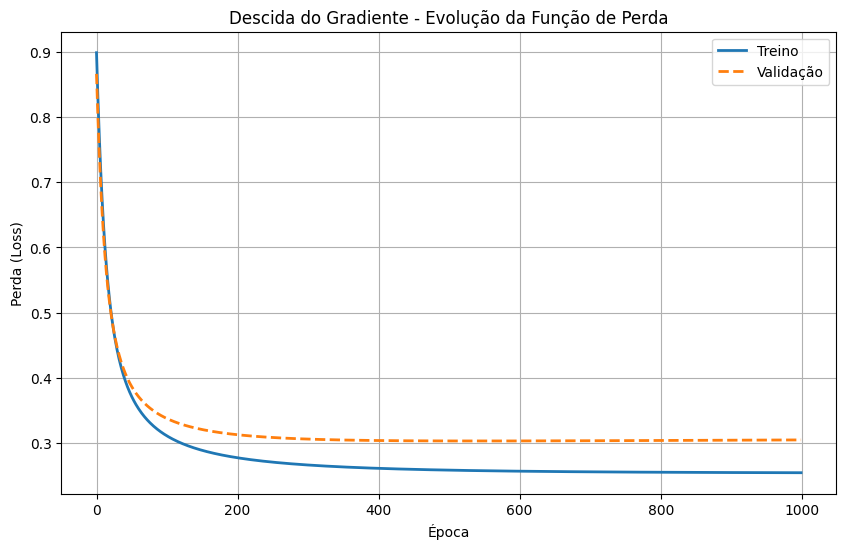

In [461]:
plt.figure(figsize=(10, 6))
plt.plot(range(n_epochs), losses, label='Treino', linewidth=2)
plt.plot(range(n_epochs), losses_test, label='Validação', linestyle='--', linewidth=2)
plt.title('Descida do Gradiente - Evolução da Função de Perda')
plt.xlabel('Época')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

### Plot Com Variáveis da Origem

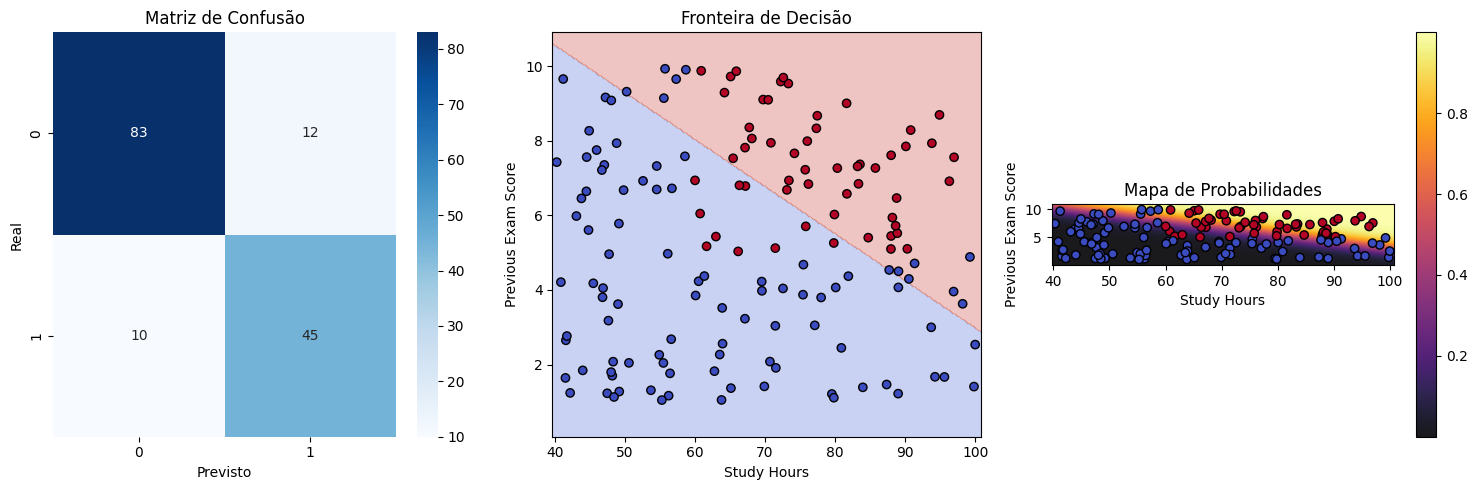

In [462]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(x_train, y_train)

y_pred_log = log_model.predict(x_test)
cm_log = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Matriz de Confusão')
ax[0].set_xlabel('Previsto')
ax[0].set_ylabel('Real')

#Daqui para baixo, muito auxilio de IA.
x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = log_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax[1].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
ax[1].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
ax[1].set_title('Fronteira de Decisão')
ax[1].set_xlabel('Study Hours')
ax[1].set_ylabel('Previous Exam Score')

probs = log_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
probs = probs.reshape(xx.shape)
im = ax[2].imshow(probs, extent=[x_min, x_max, y_min, y_max],
                  origin='lower', cmap='inferno', alpha=0.9)
ax[2].scatter(x_test[:, 0], x_test[:, 1], c=y_test, edgecolor='k', cmap='coolwarm')
ax[2].set_title('Mapa de Probabilidades')
ax[2].set_xlabel('Study Hours')
ax[2].set_ylabel('Previous Exam Score')
fig.colorbar(im, ax=ax[2])

plt.tight_layout()
plt.show()

In [466]:
y_pred_log = log_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred_log)

print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        95
           1       0.79      0.82      0.80        55

    accuracy                           0.85       150
   macro avg       0.84      0.85      0.84       150
weighted avg       0.85      0.85      0.85       150



# Conclusão (Aprendizado)

Ao contrário do exemplo no exercício modelo, este tiveram apenas 1 neurónio de saída, pois de acordo com as pesquisas seria apenas uma classe binária. Isso fez com que alguns outros tópicos dos exemplos fossem modificados como o método de calcular a perda, a troca de softmax usado para multiclasses por sigmoid que são para classes binárias e com isto foi desenvolvido o restante do exercício.


Mostrado duas vezes em escalas diferentes com libs diferentes para melhorar avaliação.

* Aparentemente o modelo foi treinando corretamente e está generalizando bem.
A perda converge rápido e se estabiliza, apesar de achar que ainda daria para diminuir mais.

* A fronteira de decisão também parece ser coerente, o modelo encontrou leve grau de incerteza em classificar alunos que ficaram pouco próximo ao centro.

* O mapa de probabilidades mostra uma transição realista, principalmente quando visto no segundo gráfico onde é exibido com a escala digamos "original".